In [3]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
#import scipy as sci
import matplotlib.tri as tri


In [4]:
class Astro:
    def __init__(self,M=1,rh=2,J=0):
        self.M=M
        self.J=J
        self.rh=rh

        if J==0:
            self.schwarzschild()
        else:
            self.kerr()
            
    def schwarzschild(self):

        M=self.M
        def gtt(r,theta=np.pi/2):
            return -(1.-2.*M/r)
        def gtp(r,theta=np.pi/2):
            return 0
        def gpp(r,theta=np.pi/2):
            return r**2*np.sin(theta)**2
        def dgtt(r,theta=np.pi/2):
            return -2.*M/r**2
        def dgtp(r,theta=np.pi/2):
            return 0
        def dgpp(r,theta=np.pi/2):
            return 2.*r*np.sin(theta)**2

        self.gtt=gtt
        self.gtp=gtp
        self.gpp=gpp
        self.dgtt=dgtt
        self.dgtp=dgtp
        self.dgpp=dgpp
        self.rh=2.*M
        
    def kerr(self):
        a=self.J/self.M
        M=self.M
        def gtt(r,th=np.pi/2):
            return -(1-2*M*r/(r**2+a**2*np.cos(th)**2))

        def gtp(r,th=np.pi/2):
            return -(4*r*2*M*a*np.sin(th)**2)/(r**2+a**2*np.cos(th)**2)

        def gpp(r,th=np.pi/2):
            return (r**2+a**2+2*M*r*a**2*np.sin(th)**2/(r**2+a**2*np.cos(th)**2))*np.sin(th)**2

        def dgtt(r,th=np.pi/2):
            return -(2.*M*(r**2-a**2*np.cos(th)**2))/(a**2*np.cos(th)**2+r**2)**2
        
        def dgtp(r,th=np.pi/2):
            return (8.*a*M*np.sin(th)**2*(a**2*np.cos(th)**2-r**2))/(a**2*np.cos(th)**2+r**2)**2
        
        def dgpp(r,th=np.pi/2):
            return np.sin(th)**2*((2.*a**2*M*np.sin(th)**2)/(a**2*np.cos(th)**2+r**2)-(4.*a**2*M*r**2*np.sin(th)**2)/(a**2*np.cos(th)**2+r**2)**2+2.*r)

        self.gtt=gtt
        self.gtp=gtp
        self.gpp=gpp
        self.dgtt=dgtt
        self.dgtp=dgtp
        self.dgpp=dgpp
        rs=M*2.
        self.rh=(rs+np.sqrt(rs**2-4.*a**2))/2.


    def load_metric(self):
        
        #loads metric as dataframe and outputs it as funtions at the equatorial plane for l_k plots!
        #For 2D use generate_torus

        if self.filename == None: 
            print('Please provide a metric file') 
            return

        c_names=['x', 'y', 'f0', 'f1', 'f2', 'om', 'phi']
        SK2=pd.read_csv(self.filename,delim_whitespace=True,names=c_names)
        SK2['r']=np.sqrt(SK2['x']**2 + self.rh**2*(SK2['x']-1.0)**2)/(1.0-SK2['x'])
        print(np.sqrt(0.002**2 + self.rh**2*(0.002-1.0)**2)/(1-0.002))
        SK2['N']=1.0-self.rh/SK2['r']
        SK2['alpha']=np.sqrt(SK2['N']*np.exp(2*SK2['f0']))
        SK2['B']=np.exp(SK2['f2'])
        SK2['beta']=SK2['om']/SK2['r']
        SK2['gtt']=-SK2['alpha']**2+SK2['beta']**2*SK2['B']**2*SK2['r']**2*np.sin(SK2['y'])**2
        SK2['gpp']=SK2['B']**2*SK2['r']**2*np.sin(SK2['y'])**2
        SK2['gtp']=SK2['gpp']*SK2['beta']
        SK2.drop(columns=['beta','B','alpha','x','N','f0','f1','f2','om'],inplace=True)
        SK2_eq=SK2.loc[(SK2.y==SK2.y.max())]

        r_values=SK2_eq.loc[(SK2_eq.gtt<1000)].r.to_numpy()
        gtt_values=SK2_eq.loc[(SK2_eq.gtt<1000)].gtt.to_numpy()
        gtp_values=SK2_eq.loc[(SK2_eq.gtt<1000)].gtp.to_numpy()
        gpp_values=SK2_eq.loc[(SK2_eq.gtt<1000)].gpp.to_numpy()
        gtt=interpolate.InterpolatedUnivariateSpline(r_values,gtt_values,k=4)
        gtp=interpolate.InterpolatedUnivariateSpline(r_values,gtp_values,k=4)
        gpp=interpolate.InterpolatedUnivariateSpline(r_values,gpp_values,k=4)
        dgtt=gtt.derivative()
        dgtp=gtp.derivative()
        dgpp=gpp.derivative()

        ddgtt=gtt.derivative(2)
        ddgtp=gtp.derivative(2)
        ddgpp=gpp.derivative(2)


        self.data=SK2
        self.data_eq=SK2_eq
        self.gtt=gtt
        self.gtp=gtp
        self.gpp=gpp
        self.dgtt=dgtt
        self.dgtp=dgtp
        self.dgpp=dgpp
        self.ddgtt=ddgtt
        self.ddgtp=ddgtp
        self.ddgpp=ddgpp

                
    def Kepler(self,r):
    
        gtt_,gtp_,gpp_,dgtt_,dgtp_,dgpp_=\
        self.gtt(r),self.gtp(r),self.gpp(r),self.dgtt(r),self.dgtp(r),self.dgpp(r)

        Omega_P=(-dgtp_+np.sqrt(dgtp_**2-dgtt_*dgpp_))/dgpp_
        Omega_M=(-dgtp_-np.sqrt(dgtp_**2-dgtt_*dgpp_))/dgpp_
    
        aux_P=np.sqrt(-gtt_-2.0*gtp_*Omega_P-gpp_*Omega_P**2)
        aux_M=np.sqrt(-gtt_-2.0*gtp_*Omega_M-gpp_*Omega_M**2)
        
        L_P=(gtp_+gpp_*Omega_P)/aux_P
        E_P=-(gtt_+gtp_*Omega_P)/aux_P

        L_M=(gtp_+gpp_*Omega_M)/aux_M
        E_M=-(gtt_+gtp_*Omega_M)/aux_M

        l_P=L_P/E_P
        l_M=L_M/E_M

        return r,Omega_P, Omega_M, L_P, L_M, E_P, E_M, l_P, l_M
    
    def Torus(self,r=None,theta=None,l=0):
        
        if r is None:
            return
        if theta is None:
            THETA=np.pi/2
            R=r
            gtt=self.gtt(r=R)
            gtp=self.gtp(r=R)
            gpp=self.gpp(r=R)
        else:    
            R,THETA=np.meshgrid(r,theta)
            gtt=self.gtt(r=R,theta=THETA)
            gtp=self.gtp(r=R,theta=THETA)
            gpp=self.gpp(r=R,theta=THETA)

        rho_=gtp**2-gtt*gpp
        W=rho_/(gpp+2.0*l*gtp+l**2*gtt)
        Om=-(l*gtt+gtp)/(l*gtt+gpp)
        
        return R,THETA,W,Om
    
##Not part of the class!

def local_extrema(r,pot):

    Min_r=r[np.r_[True,pot[1:]<pot[:-1]]  & np.r_[pot[:-1]<pot[1:],True]]
    Max_r=r[np.r_[pot[1:]<pot[:-1],False]  & np.r_[True,pot[:-1]<pot[1:]]]

    Min_p=pot[np.r_[True,pot[1:]<pot[:-1]]  & np.r_[pot[:-1]<pot[1:],True]]
    Max_p=pot[np.r_[pot[1:]<pot[:-1],False]  & np.r_[True,pot[:-1]<pot[1:]]]

    return Max_r,Min_r,Max_p,Min_p



<ipython-input-4-dfbcf89f99f7>:127: RuntimeWarning: invalid value encountered in sqrt
  aux_P=np.sqrt(-gtt_-2.0*gtp_*Omega_P-gpp_*Omega_P**2)
<ipython-input-4-dfbcf89f99f7>:128: RuntimeWarning: invalid value encountered in sqrt
  aux_M=np.sqrt(-gtt_-2.0*gtp_*Omega_M-gpp_*Omega_M**2)


Text(0, 0.5, '$l_k^{\\pm}$')

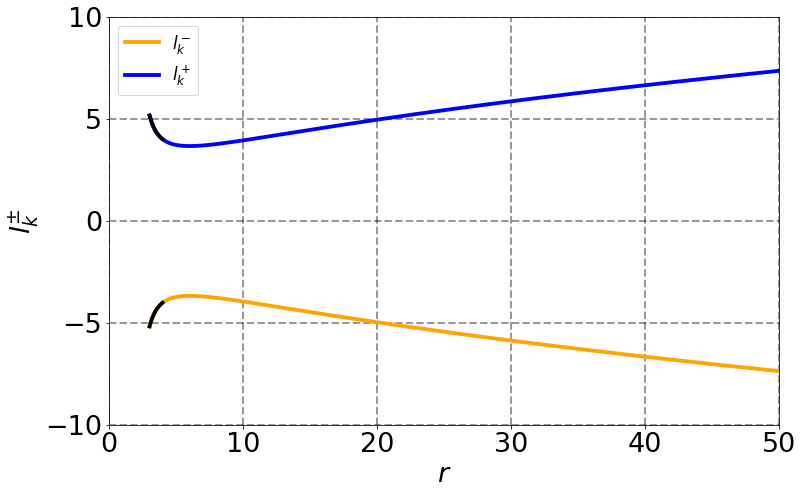

In [5]:
#Generate Keplerian Orbits
r_range=np.linspace(2.,50,1000)
Sol=Astro()
rm, Omega_P, Omega_M, L_P, L_M, E_P, E_M ,l_P,l_M= Sol.Kepler(r_range)

#Plots the Keplerian distribution of specific angular momenta (Retrograde and Prograde)

plt.rcParams.update({'font.size': 27})
fig, ax = plt.subplots(figsize=(12,7.5))
ax.grid('--g',linewidth=2,linestyle='--',color='k',alpha=0.4)

lw=3.8
ax.set_xlim(0,50)
ax.set_ylim(-10,10)

ax.plot(rm,l_M,linewidth=lw,color='orange',linestyle='-',label=r'$l^-_k $')
unb=np.where(E_M<1,np.nan,l_M)
ax.plot(rm,unb,linewidth=lw,color='black',linestyle='-')
ax.plot(rm,l_P,linewidth=lw,color='blue',linestyle='-',label=r'$l^+_k $')
unb=np.where(E_P<1,np.nan,l_P)
ax.plot(rm,unb,linewidth=lw,color='black',linestyle='-')
ax.legend(fontsize=17)#,loc='center right')

ax.set_xlabel(r'$r$')
ax.set_ylabel(r'$l_k^{\pm}$')
#fig.savefig("S3_l_far.png",format='png',dpi=200,bbox_inches = 'tight')

<ipython-input-6-8f543dc8cdb7>:13: RuntimeWarning: divide by zero encountered in log
  pot=np.log(pot)/2


Text(0, 0.5, '$\\mathcal{W}$')

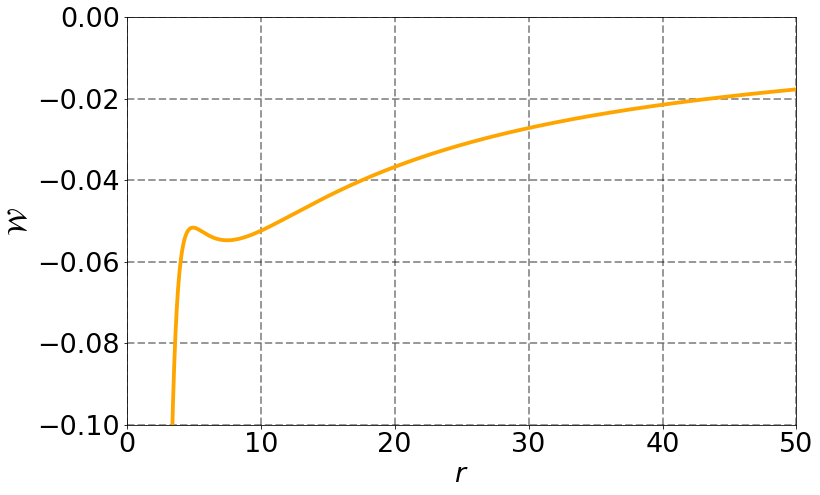

In [6]:
#generates torus with specific angular momentum l

r_range=np.linspace(2.,50,1000)
r,th,pot,om = Sol.Torus(r=r_range,l=3.734471982989768)

plt.rcParams.update({'font.size': 27})
fig, ax = plt.subplots(figsize=(12,7.5))
lw=3.8

ax.set_xlim(0,50)
#ax.set_ylim(-0.5,0)
ax.grid('--g',linewidth=2,linestyle='--',color='k',alpha=0.4)

pot=np.log(pot)/2

ax.plot(r_range,pot,linewidth=lw,color='orange',linestyle='-',label=r'$l^-_k S3$')

ax.set_ylim(-0.1,0)

ax.set_xlabel(r'$r$')
ax.set_ylabel(r'$\mathcal{W}$')
#fig.savefig("S3_l_close.png",format='png',dpi=200,bbox_inches = 'tight')

<ipython-input-4-dfbcf89f99f7>:158: RuntimeWarning: invalid value encountered in true_divide
  W=rho_/(gpp+2.0*l*gtp+l**2*gtt)
<ipython-input-4-dfbcf89f99f7>:159: RuntimeWarning: invalid value encountered in true_divide
  Om=-(l*gtt+gtp)/(l*gtt+gpp)
<ipython-input-8-98a8b11e5bad>:16: RuntimeWarning: divide by zero encountered in log
  WW=np.log(np.reshape(W,len(R[:,0])*len(R[0,:])))/2
<ipython-input-8-98a8b11e5bad>:16: RuntimeWarning: invalid value encountered in log
  WW=np.log(np.reshape(W,len(R[:,0])*len(R[0,:])))/2


Text(0, 0.5, 'y')

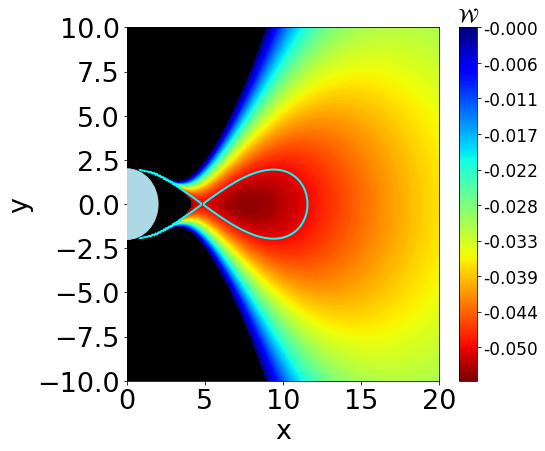

In [8]:
#generates torus with specific angular momentum l (now 2D)

theta_range=np.linspace(0,np.pi/2,100)
r_range=np.linspace(2,50,500)
R,T,W,Om=Sol.Torus(l=3.75,r=r_range,theta=theta_range)

fig, ax = plt.subplots(figsize=(7,6.5))
plt.rcParams.update({'font.size': 17})

vmax=-0.0
vmin=local_extrema(r=r,pot=pot)[3][1]

y1=np.reshape(R,len(R[:,0])*len(R[0,:]))*np.cos(np.reshape(T,len(T[:,0])*len(T[0,:])))
x1=np.reshape(R,len(R[:,0])*len(R[0,:]))*np.sin(np.reshape(T,len(T[:,0])*len(T[0,:])))
y2=-y1
WW=np.log(np.reshape(W,len(R[:,0])*len(R[0,:])))/2
Om_=np.reshape(Om,len(R[:,0])*len(R[0,:]))

mask = ~(np.greater(WW, 100) | np.isnan(WW) | np.less(WW, -100) )
x1=x1[mask]
y1=y1[mask]
y2=y2[mask]
Om_=Om_[mask]
WW=WW[mask]
WW[np.less(WW,vmin)]=vmin-100


triang = tri.Triangulation(x1, y1)
triang2 = tri.Triangulation(x1, y2)

space_color=200
mylevels=np.linspace(vmin,vmax,space_color)

colors=plt.cm.jet_r(np.linspace(0, 1, 1000))
cmap = mpl.colors.LinearSegmentedColormap.from_list('colormap', colors)
tcf = ax.tricontourf(triang, WW, levels=mylevels,vmax=vmax,vmin=vmin,cmap=cmap)
tcf2 = ax.tricontourf(triang2, WW, levels=mylevels,vmax=vmax,vmin=vmin,cmap=cmap)
cbar=fig.colorbar(tcf,format="%1.3f")
cbar.ax.set_title(r'$\mathcal{W}$')
ax.set_facecolor('k')

mylevels=[-0.04944963]#,-0.04]
ax.tricontour(triang, WW, levels=mylevels, colors='cyan',linestyles='solid',linewidths=2,alpha=1)
ax.tricontour(triang2, WW, levels=mylevels , colors='cyan',linestyles='solid',linewidths=2,alpha=1)

draw_circle =plt.Circle((0, 0), Sol.rh,zorder=10,color='lightblue')
ax.add_artist(draw_circle)

ax.set_xlim(0,20)
ax.set_ylim(-10,10)
ax.set_xlabel('x')
ax.set_ylabel('y')
#fig.savefig("S2_lplus008_far.png",format='png',dpi=200,bbox_inches = 'tight')